# 同時確率密度関数のプロット

In [8]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# グリッド作成
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y) #格子点（meshgrid）とは、2次元以上の空間において規則的に配置された点の集合。np.meshgrid()関数を使用すると、1次元の配列から多次元の格子点を生成する。

# 関数定義
f_xy = (1/(4*np.pi)) * np.exp(-(1/2) * (X**2/4 + Y**2))
g_x = (1/(2*np.sqrt(2*np.pi))) * np.exp(-x**2/8)
h_y = (1/np.sqrt(2*np.pi)) * np.exp(-y**2/2)
gh_xy = np.outer(g_x, h_y)

# サブプロット作成（1行2列）
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=['joint probability density function f(x,y)', 'product of two density functions g(x) × h(y)']
)

# 3D surface plots
fig.add_trace(go.Surface(x=X, y=Y, z=f_xy, colorscale='Viridis'), row=1, col=1)
fig.add_trace(go.Surface(x=X, y=Y, z=gh_xy, colorscale='Plasma'), row=1, col=2)

fig.show()

# 第一種誤りと第二種誤り(機械学習の部分は飛ばしていい、混同行列の部分に注目)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings("ignore")

!pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline


=== エラータイプ ===
False Negative（第一種の誤り）: 良性を悪性と誤分類（右上）誤ってがんだと判断（タイプⅠエラー）
False Positive（第二種の誤り）: 悪性を良性と誤分類（左下）がんを見逃す（タイプⅡエラー）← こちらが重大


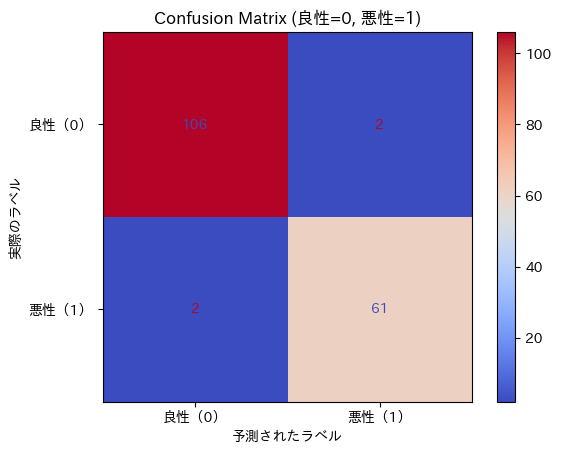


=== 混同行列の解説 ===
True Negative（正しく良性と判断）: 106
False Positive（第一種誤り：良性をがんと誤診）: 2
False Negative（第二種誤り：悪性を良性と見逃す）: 2
True Positive（正しくがんと判断）: 61


In [ ]:
# データ読み込みと反転
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)

# 反転：良性→0，悪性→1 に変換（元は 0:悪性, 1:良性）
y_original = pd.Series(data.target)
y = 1 - y_original  # 0→1, 1→0（良性:0, 悪性:1）

# train-test 分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ロジスティック回帰モデルで分類
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# エラーの意味
print("\n=== エラータイプ ===")
print("False Negative（第一種の誤り）: 良性を悪性と誤分類（右上）誤ってがんだと判断（タイプⅠエラー）")
print("False Positive（第二種の誤り）: 悪性を良性と誤分類（左下）がんを見逃す（タイプⅡエラー）← こちらが重大")

# 混同行列の描画（0:良性, 1:悪性）
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["良性（0）", "悪性（1）"])
disp.plot(cmap='coolwarm')
plt.title('Confusion Matrix (良性=0, 悪性=1)')
plt.xlabel('予測されたラベル')
plt.ylabel('実際のラベル')
plt.show()

# 誤りのカウントと解説
tn, fp, fn, tp = cm.ravel()

print("\n=== 混同行列の解説 ===")
print(f"True Negative（正しく良性と判断）: {tn}")
print(f"False Positive（第一種誤り：良性をがんと誤診）: {fp}")
print(f"False Negative（第二種誤り：悪性を良性と見逃す）: {fn}")
print(f"True Positive（正しくがんと判断）: {tp}")


# 「mean perimeter」の説明変数で良性 vs 悪性 の平均値の差の検定（t検定）

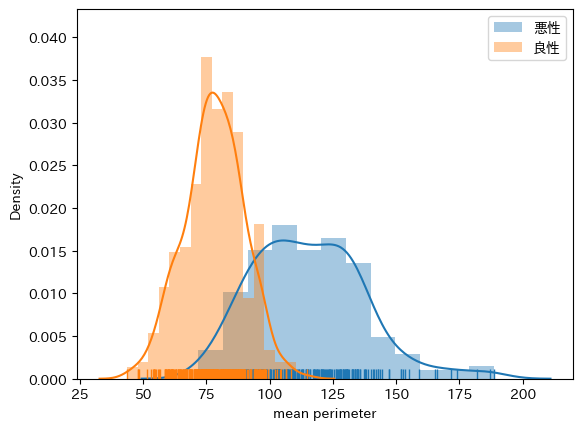

In [ ]:
# この説明変数のデータは良性と悪性の二母集団からの標本分布とする、その標本分布を確認する

mean_radius = X['mean perimeter']
malignant_radius = mean_radius[y == 1]  # 悪性
benign_radius = mean_radius[y == 0]     # 良性

sns.distplot(malignant_radius, hist=True, rug=True,label='悪性')
sns.distplot(benign_radius, hist=True, rug=True,label='良性')
plt.legend()
plt.show()

In [ ]:
# 「mean perimeter」の説明変数で良性 vs 悪性 の平均値の差のt検定：ttest_ind()を使う

t_stat, p_value = ttest_ind(malignant_radius, benign_radius, equal_var=False)

print("\n=== [mean perimeter]に基づくt検定 ===")
print(f"悪性の平均: {malignant_radius.mean():.2f}, 良性の平均: {benign_radius.mean():.2f}")
print(f"t統計量: {t_stat:.4f}, p値: {p_value:.4e}")

if p_value < 0.05:
    print("→ 有意差あり：悪性と良性で[mean perimeter]の平均は異なる")
else:
    print("→ 有意差なし：悪性と良性で[mean perimeter]の平均に差はない")



=== [mean perimeter]に基づくt検定 ===
悪性の平均: 115.37, 良性の平均: 78.08
t統計量: 22.9353, p値: 1.0231e-66
→ 有意差あり：悪性と良性で[mean perimeter]の平均は異なる


In [ ]:
#「mean perimeter」の説明変数で良性 vs 悪性 の平均値の差のt検定の手計算

# サンプル情報
n1 = len(malignant_radius)
n2 = len(benign_radius)
mean1 = np.mean(malignant_radius)
mean2 = np.mean(benign_radius)
var1 = np.var(malignant_radius, ddof=1)  # 標本分散
var2 = np.var(benign_radius, ddof=1)

# t値（Welchのt検定）
t_stat_manual = (mean1 - mean2) / np.sqrt(var1/n1 + var2/n2)

# 自由度（Welch–Satterthwaite equation）
df = (var1/n1 + var2/n2)**2 / ((var1**2)/(n1**2 * (n1-1)) + (var2**2)/(n2**2 * (n2-1)))

# p値（両側検定）
from scipy.stats import t
p_manual = 2 * (1 - t.cdf(np.abs(t_stat_manual), df))

print("\n=== t検定の手計算（Welch） ===")
print(f"t値: {t_stat_manual:.4f}")
print(f"自由度: {df:.2f}")
print(f"p値: {p_manual:.4e}")

if p_manual < 0.05:
    print("→ 有意差あり")
else:
    print("→ 有意差なし")



=== t検定の手計算（Welch） ===
t値: 22.9353
自由度: 285.41
p値: 0.0000e+00
→ 有意差あり


# 第5部　統計的推定


## 5章　正規母集団から派生した確率分布

### 実装：分析の準備

In [ ]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
from scipy import stats

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

!pip install japanize-matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib

# # グラフの日本語表記
# from matplotlib import rcParams
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = 'Meiryo'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 50.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=e999cfdc0c719403f169ec5663ec3cfe375c4eda47c3f892b60e743f95c0980b
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize-matplotlib


In [ ]:
# 表示設定(書籍本文のレイアウトと合わせるためであり、必須ではありません)
np.set_printoptions(linewidth=60)
pd.set_option('display.width', 60)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

### 実装：シミュレーションの準備

In [ ]:
# 平均4、標準偏差0.8の正規分布を使いまわす
# なお、muとsigmaの数値を変えても、以下の結果はほとんど変化しない
mu = 4
sigma = 0.8
population = stats.norm(loc=mu, scale=sigma)

In [ ]:
# サンプルサイズ
n = 5

# 標本抽出
np.random.seed(1)
sample = population.rvs(size=n)
sample

array([5.29947629, 3.51059487, 3.5774626 , 3.1416251 ,
       4.6923261 ])

### 実装：χ2分布

#### Pythonにおける扱い

In [ ]:
# 確率密度関数
round(stats.chi2.pdf(x=2, df=n - 1), 3)

np.float64(0.184)

In [ ]:
# 累積分布関数
round(stats.chi2.cdf(x=2, df=n - 1), 3)

np.float64(0.264)

In [ ]:
# パーセント点
round(stats.chi2.ppf(q=0.5, df=n - 1), 3)

np.float64(3.357)

#### シミュレーション

In [ ]:
# サンプルサイズ
n = 5

# 乱数の種
np.random.seed(1)

# χ2値を格納する入れ物
chi2_value_array = np.zeros(10000)

# シミュレーションの実行
for i in range(0, 10000):
    sample = population.rvs(size=n)
    u2 = np.var(sample, ddof=1)     # 不偏分散
    chi2 = (n - 1) * u2 / sigma**2  # χ2値
    chi2_value_array[i] = chi2

In [ ]:
# χ2分布

# 確率変数
x = np.arange(start=0, stop=20.1, step=0.1)

# χ2分布の確率密度
chi2_distribution = stats.chi2.pdf(x=x, df=n - 1)

# データフレームにまとめる
chi2_df = pd.DataFrame({
    'x': x,
    'chi2_distribution': chi2_distribution
})

print(chi2_df.head(3))

     x  chi2_distribution
0  0.0           0.000000
1  0.1           0.023781
2  0.2           0.045242


<Axes: xlabel='x', ylabel='Density'>

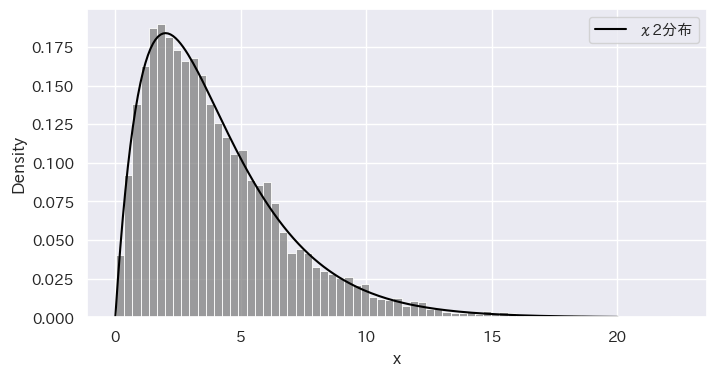

In [ ]:
# ヒストグラム
sns.histplot(chi2_value_array, color='gray', stat='density')

# χ2分布
sns.lineplot(x='x', y='chi2_distribution',
             data=chi2_df, color='black',
             label='χ2分布')

### 実装：標本平均の標準化

In [ ]:
# サンプルサイズ
n = 3

# 乱数の種
np.random.seed(1)

# z値を格納する入れ物
z_value_array = np.zeros(10000)

# シミュレーションの実行
for i in range(0, 10000):
    sample = population.rvs(size=n)
    x_bar = np.mean(sample)            # 標本平均
    bar_sigma = sigma / np.sqrt(n)     # 標本平均の標準偏差
    z_value_array[i]  = (x_bar - mu) / bar_sigma   # z値

In [ ]:
# 標準正規分布

# 確率変数
x = np.arange(start=-6, stop=6.1, step=0.1)

# 標準正規分布の確率密度
z_distribution = stats.norm.pdf(x=x, loc=0, scale=1)

# データフレームにまとめる
z_df = pd.DataFrame({
    'x': x,
    'z_distribution': z_distribution
})

print(z_df.head(3))

     x  z_distribution
0 -6.0    6.075883e-09
1 -5.9    1.101576e-08
2 -5.8    1.977320e-08


(-6.0, 6.0)

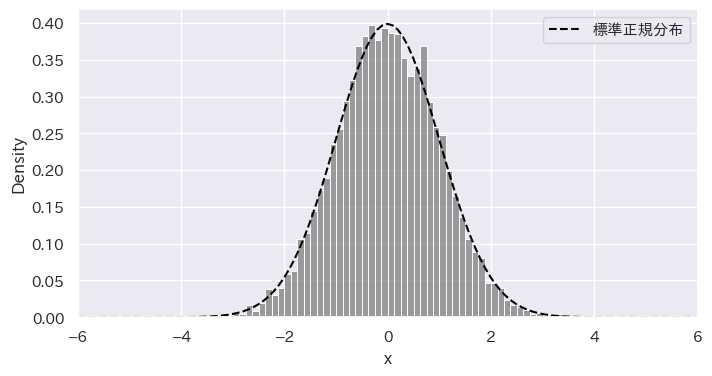

In [ ]:
# z値のヒストグラム
sns.histplot(z_value_array, color='gray', stat='density')

# 標準正規分布
sns.lineplot(x='x', y='z_distribution', data=z_df,
             color='black', linestyle='dashed',
             label='標準正規分布')

# X軸範囲
plt.xlim(-6, 6)

### 実装：t分布

#### Pythonにおける扱い

In [ ]:
# 確率密度関数
round(stats.t.pdf(x=2, df=n - 1), 3)

np.float64(0.068)

In [ ]:
# 累積分布関数
round(stats.t.cdf(x=2, df=n - 1), 3)

np.float64(0.908)

In [ ]:
# パーセント点
round(stats.t.ppf(q=0.5, df=n - 1), 3)

np.float64(0.0)

#### シミュレーション

In [ ]:
# 乱数の種
np.random.seed(1)

# t値を格納する入れ物
t_value_array = np.zeros(10000)

# シミュレーションの実行
for i in range(0, 10000):
    sample = population.rvs(size=n)
    x_bar = np.mean(sample)                # 標本平均
    u = np.std(sample, ddof=1)             # 標準偏差
    se = u / np.sqrt(n)                    # 標準誤差
    t_value_array[i]  = (x_bar - mu) / se  # t値

In [ ]:
# t分布

# t分布の確率密度
t_distribution = stats.t.pdf(x=x, df=n - 1)

# データフレームにまとめる
t_df = pd.DataFrame({
    'x': x,
    't_distribution': t_distribution
})

print(t_df.head(3))

     x  t_distribution
0 -6.0        0.004269
1 -5.9        0.004478
2 -5.8        0.004700


(-6.0, 6.0)

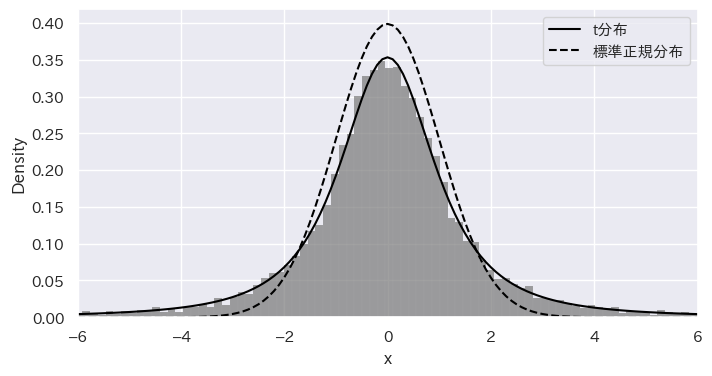

In [ ]:
# t値のヒストグラム
sns.histplot(t_value_array, color='gray', stat='density')

# t分布
sns.lineplot(x='x', y='t_distribution',
             data=t_df, color='black',
             label='t分布')

# 標準正規分布
sns.lineplot(x='x', y='z_distribution', data=z_df,
             color='black', linestyle='dashed',
             label='標準正規分布')

# X軸範囲
plt.xlim(-6, 6)

### 実装：F分布

#### Pythonにおける扱い

In [ ]:
# サンプルサイズ
m = 5
n = 10

In [ ]:
# 確率密度関数
round(stats.f.pdf(x=2, dfn=m - 1, dfd=n - 1), 3)

np.float64(0.157)

In [ ]:
# 累積分布関数
round(stats.f.cdf(x=2, dfn=m - 1, dfd=n - 1), 3)

np.float64(0.822)

In [ ]:
# パーセント点
round(stats.f.ppf(q=0.5, dfn=m - 1, dfd=n - 1), 3)

np.float64(0.906)

#### シミュレーション

In [ ]:
# サンプルサイズ
m = 5
n = 10

# 乱数の種
np.random.seed(1)

# F比を格納する入れ物
f_value_array = np.zeros(10000)

# シミュレーションの実行
for i in range(0, 10000):
    sample_x = population.rvs(size=m) # サンプルXの取得
    sample_y = population.rvs(size=n) # サンプルYの取得
    u2_x = np.var(sample_x, ddof=1)   # Xの不偏分散
    u2_y = np.var(sample_y, ddof=1)   # Yの不偏分散
    f_value_array[i]  = u2_x / u2_y   # F比

In [ ]:
# F分布

# 確率変数
x = np.arange(start=0, stop=6.1, step=0.1)

# F分布の確率密度
f_distribution = stats.f.pdf(x=x, dfn=m - 1,dfd=n - 1)

# データフレームにまとめる
f_df = pd.DataFrame({
    'x': x,
    'f_distribution': f_distribution
})

print(f_df.head(3))

     x  f_distribution
0  0.0        0.000000
1  0.1        0.368515
2  0.2        0.562143


(0.0, 6.0)

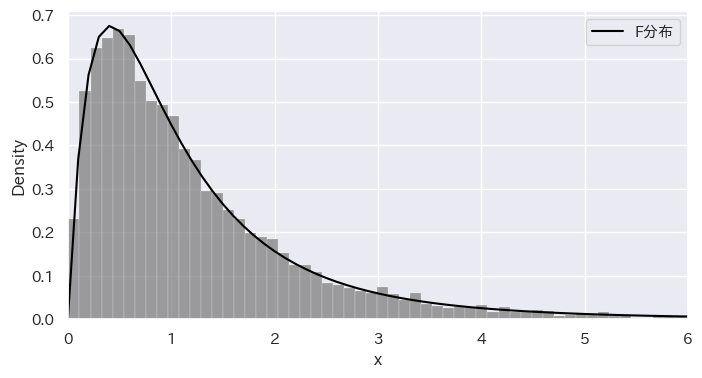

In [ ]:
# F比のヒストグラム
sns.histplot(f_value_array, color='gray', stat='density')

# F分布
sns.lineplot(x='x', y='f_distribution',
             data=f_df, color='black',
             label='F分布')

# X軸範囲
plt.xlim(0, 6)

## 6章　区間推定

### 実装：分析の準備

In [ ]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
from scipy import stats

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# # グラフの日本語表記
# from matplotlib import rcParams
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = 'Meiryo'

In [ ]:
# 表示設定(書籍本文のレイアウトと合わせるためであり、必須ではありません)
np.set_printoptions(linewidth=60)
pd.set_option('display.width', 60)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

In [ ]:
# データの読み込み
fish = pd.read_csv('5-6-1-fish_length.csv')['length']
fish

,length
0,4.352982
1,3.735304
2,5.944617
3,3.798326
4,4.087688
5,5.265985
6,3.272614
7,3.526691
8,4.150083
9,3.736104


### 実装：点推定

In [ ]:
# 点推定
x_bar = np.mean(fish)
u2 = np.var(fish, ddof=1)

print('標本平均：', round(x_bar, 3))
print('不偏分散：', round(u2, 3))

標本平均： 4.187
不偏分散： 0.68


### 実装：母平均の区間推定

#### 定義通りの実装

In [ ]:
# 統計量の計算
n = len(fish)            # サンプルサイズ
df = n - 1               # 自由度
u = np.std(fish, ddof=1) # 標準偏差
se = u / np.sqrt(n)      # 標準誤差

print('サンプルサイズ：', n)
print('自由度　　　　：', df)
print('標準偏差　　　：', round(u, 3))
print('標準誤差　　　：', round(se, 3))
print('標本平均　　　：', round(x_bar, 3))

サンプルサイズ： 10
自由度　　　　： 9
標準偏差　　　： 0.825
標準誤差　　　： 0.261
標本平均　　　： 4.187


In [ ]:
# 2.5%点と97.5%点
t_025 = stats.t.ppf(q=0.025, df=df)
t_975 = stats.t.ppf(q=0.975, df=df)

print('t分布の 2.5%点：', round(t_025, 3))
print('t分布の97.5%点：', round(t_975, 3))

t分布の 2.5%点： -2.262
t分布の97.5%点： 2.262


In [ ]:
# 母平均の区間推定
lower_mu = x_bar - t_975 * se
upper_mu = x_bar - t_025 * se

print('下側信頼限界：', round(lower_mu, 3))
print('上側信頼限界：', round(upper_mu, 3))

下側信頼限界： 3.597
上側信頼限界： 4.777


#### 簡単な実装方法

In [ ]:
# 区間推定
res_1 = stats.t.interval(0.95, df=df, loc=x_bar, scale=se)
np.round(res_1, 3)

array([3.597, 4.777])

### 信頼区間の幅を決める要素

In [ ]:
# 標準偏差が大きいと、信頼区間は広くなる
se_2 = (u * 10) / np.sqrt(n)
res_2 = stats.t.interval(0.95, df=df, loc=x_bar, scale=se_2)
np.round(res_2, 3)

array([-1.713, 10.087])

In [ ]:
# サンプルサイズが大きいと、信頼区間は狭くなる
n_2 = n * 10
df_2 = n_2 - 1
se_3 = u / np.sqrt(n_2)
res_3 = stats.t.interval(0.95, df=df_2, loc=x_bar, scale=se_3)
np.round(res_3, 3)

array([4.023, 4.351])

In [ ]:
# 99%信頼区間
res_4 = stats.t.interval(0.99, df=df, loc=x_bar, scale=se)
np.round(res_4, 3)

array([3.339, 5.035])

### 区間推定の結果の解釈

In [ ]:
# 母集団分布（母平均は4）
norm_dist = stats.norm(loc=4, scale=0.8)

In [ ]:
num_trials = 20000 # シミュレーションの繰り返し数
included_num = 0   # 信頼区間が母平均(4)を含んでいた回数

In [ ]:
# 「データを10個選んで95%信頼区間を求める」試行を20000回繰り返す
np.random.seed(1) # 乱数の種
for i in range(0, num_trials):
    # 標本の抽出
    sample = norm_dist.rvs(size=n)
    # 信頼区間の計算
    df = n - 1                 # 自由度
    x_bar = np.mean(sample)    # 標本平均
    u = np.std(sample, ddof=1) # 標準偏差
    se = u / np.sqrt(n)        # 標準誤差
    interval = stats.t.interval(0.95, df, x_bar, se)
    # 信頼区間が母平均(4)を含んでいた回数をカウント
    if(interval[0] <= 4 <= interval[1]):
        included_num = included_num + 1

In [ ]:
# 全試行中、信頼区間が母平均（4）を含んでいた割合
included_num / num_trials

0.948

### 実装：母分散の区間推定

In [ ]:
# 2.5%点と97.5%点
chi2_025 = stats.chi2.ppf(q=0.025, df=df)
chi2_975 = stats.chi2.ppf(q=0.975, df=df)

print('χ2分布の 2.5%点：', round(chi2_025, 3))
print('χ2分布の97.5%点：', round(chi2_975, 3))

χ2分布の 2.5%点： 2.7
χ2分布の97.5%点： 19.023


In [ ]:
# 母分散の区間推定
upper_sigma = (n - 1) * u2 / chi2_025
lower_sigma = (n - 1) * u2 / chi2_975

print('下側信頼限界：', round(lower_sigma, 3))
print('上側信頼限界：', round(upper_sigma, 3))

下側信頼限界： 0.322
上側信頼限界： 2.267


# 第6部　統計的仮説検定

## 1章　母平均に関する1標本のt検定

### 実装：分析の準備

In [ ]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
from scipy import stats

In [ ]:
# 表示設定(書籍本文のレイアウトと合わせるためであり、必須ではありません)
np.set_printoptions(linewidth=60)
pd.set_option('display.width', 60)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

In [ ]:
# データの読み込み
junk_food = pd.read_csv('6-1-1-junk-food-weight.csv')['weight']
junk_food.head()

,weight
0,58.529820
1,52.353039
2,74.446169
3,52.983263
4,55.876879


### 実装：t値の計算

In [ ]:
# 標本平均
x_bar = np.mean(junk_food)
round(x_bar, 3)

np.float64(55.385)

In [ ]:
# 自由度
n = len(junk_food)
df = n - 1
df

19

In [ ]:
# 標準誤差
u = np.std(junk_food, ddof = 1)
se = u / np.sqrt(n)
round(se, 3)

np.float64(1.958)

In [ ]:
# t値
t_sample = (x_bar - 50) / se
round(t_sample, 3)

np.float64(2.75)

### 実装：棄却域の計算

In [ ]:
# t分布の2.5%点
round(stats.t.ppf(q=0.025, df=df), 3)

np.float64(-2.093)

### 実装：p値の計算

In [ ]:
# p値
p_value = stats.t.cdf(-np.abs(t_sample), df=df) * 2
round(p_value, 3)

np.float64(0.013)

In [ ]:
# t検定
stats.ttest_1samp(junk_food, 50)

TtestResult(statistic=np.float64(2.7503396831713434), pvalue=np.float64(0.012725590012524155), df=np.int64(19))

### 実装：シミュレーションによるp値の計算

In [ ]:
# 標本の情報(一部再掲)
n = len(junk_food)
u = np.std(junk_food, ddof=1)

In [ ]:
# t値を格納する変数
t_value_array = np.zeros(50000)

In [ ]:
# 母平均が50(帰無仮説が正しい)と仮定してt値を計算することを50000回繰り返す
np.random.seed(1)
norm_dist = stats.norm(loc=50, scale=u)
for i in range(0, 50000):
    # 標本の抽出
    sample = norm_dist.rvs(size=n)
    # t値の計算
    sample_x_bar = np.mean(sample)    # 標本平均
    sample_u = np.std(sample, ddof=1) # 標準偏差
    sample_se = sample_u / np.sqrt(n) # 標準誤差
    t_value_array[i] = (sample_x_bar - 50) / sample_se # t値

In [ ]:
p_sim = (sum(t_value_array >= t_sample) / 50000) * 2
round(p_sim, 3)

np.float64(0.013)

## 2章　平均値の差の検定

### 実装：分析の準備

In [ ]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
from scipy import stats

In [ ]:
# 表示設定(書籍本文のレイアウトと合わせるためであり、必須ではありません)
np.set_printoptions(linewidth=60)
pd.set_option('display.width', 60)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

In [ ]:
# データの読み込み
paired_test_data = pd.read_csv('6-2-1-paired-t-test.csv')
print(paired_test_data)

  person medicine  body_temperature
0      A   before              36.2
1      B   before              36.2
2      C   before              35.3
3      D   before              36.1
4      E   before              36.1
5      A    after              36.8
6      B    after              36.1
7      C    after              36.8
8      D    after              37.1
9      E    after              36.9


### 実装：対応のあるt検定

In [ ]:
# 薬を飲む前と飲んだ後の標本平均
before = paired_test_data.query(
    'medicine == "before"')['body_temperature']
after = paired_test_data.query(
    'medicine == "after"')['body_temperature']
# アレイに変換
before = np.array(before)
after = np.array(after)
# 差を計算
diff = after - before
diff

array([ 0.6, -0.1,  1.5,  1. ,  0.8])

In [ ]:
# 平均値が0と異なるか検定
stats.ttest_1samp(diff, 0)

TtestResult(statistic=np.float64(2.901693483620596), pvalue=np.float64(0.044043109730074276), df=np.int64(4))

In [ ]:
# 対応のあるt検定
stats.ttest_rel(after, before)

TtestResult(statistic=np.float64(2.901693483620596), pvalue=np.float64(0.044043109730074276), df=np.int64(4))

### 実装：対応の無いt検定(不等分散)

In [ ]:
# 平均値
x_bar_bef = np.mean(before)
x_bar_aft = np.mean(after)

# 分散
u2_bef = np.var(before, ddof=1)
u2_aft = np.var(after, ddof=1)

# サンプルサイズ
m = len(before)
n = len(after)

# t値
t_value = (x_bar_aft - x_bar_bef) / \
    np.sqrt((u2_bef/m + u2_aft/n))
round(t_value, 3)

np.float64(3.156)

In [ ]:
# 自由度
df = (u2_bef / m + u2_aft / n)**2 / \
  ((u2_bef / m)**2 / (m-1) + (u2_aft / n)**2 / (n-1))
round(df, 3)

np.float64(7.998)

In [ ]:
# p値
p_value = stats.t.cdf(-np.abs(t_value), df=df) * 2
round(p_value, 5)

np.float64(0.01348)

In [ ]:
stats.ttest_ind(after, before, equal_var=False)

TtestResult(statistic=np.float64(3.1557282344421034), pvalue=np.float64(0.013484775682079892), df=np.float64(7.998478291882638))

## 3章　分割表の検定

### 実装：分析の準備

In [ ]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
from scipy import stats

In [ ]:
# 表示設定(書籍本文のレイアウトと合わせるためであり、必須ではありません)
np.set_printoptions(linewidth=60)
pd.set_option('display.width', 60)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

### 実装：p値の計算

In [ ]:
# p値を求める
1 - stats.chi2.cdf(x=6.667, df=1)

np.float64(0.009821437357809604)

### 実装：分割表の検定

In [ ]:
# データの読み込み
click_data = pd.read_csv('6-3-1-click_data.csv')
print(click_data)

  color  click  freq
0  blue  click    20
1  blue    not   230
2   red  click    10
3   red    not    40


In [ ]:
# 分割表形式に変換
cross = pd.pivot_table(
    data=click_data,
    values='freq',
    aggfunc='sum',
    index='color',
    columns='click'
)
print(cross)

click  click  not
color            
blue      20  230
red       10   40


In [ ]:
# 検定の実行
stats.chi2_contingency(cross, correction=False)

Chi2ContingencyResult(statistic=np.float64(6.666666666666666), pvalue=np.float64(0.009823274507519247), dof=1, expected_freq=array([[ 25., 225.],
       [  5.,  45.]]))